In [1]:
import glob
import pandas
import iris

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

In [3]:
## Get files

aa_physics = {'CanESM2': 'p4', 'CCSM4': 'p10', 'CSIRO-Mk3-6-0': 'p4',
              'GFDL-CM3': 'p1', 'GISS-E2-H': 'p107', 'GISS-E2-R': 'p107', 'NorESM1-M': 'p1'}

def get_file_pair(var, model, experiment):
    """Get a file pair of interest"""

    dir_experiment = 'rcp85' if experiment == 'historical-rcp85' else experiment 
    mip = 'r1i1' + aa_physics[model] if experiment == 'historicalMisc' else 'r1i1p1'
    time_info = 'all' if var in ['ohc', 'thetao'] else 'cumsum-all'
    tscale = 'Ayr' if var == 'rndt' else 'Oyr'
    realm = 'atmos' if var =='rndt' else 'ocean'
    var = 'ohc' if var == 'ohc-adjusted' else var
    agg = 'mean' if var == 'thetao' else 'sum'

    mydir = '/g/data/r87/dbi599/DRSv2/CMIP5/%s/%s/yr/%s/%s/%s/latest/dedrifted'  %(model, dir_experiment, realm, mip, var)
 
    output = {}
    for region in ['nh', 'sh']:
        file_start = '%s*%s-%s'  %(var, region, agg)
        files = glob.glob('%s/%s_*%s.nc' %(mydir, file_start, time_info))
        assert len(files) == 1, '%s/%s_*%s.nc' %(mydir, file_start, time_info)
        output[region] = files[0]
   
    return output['nh'], output['sh']

In [4]:
## Read data

names = {'ohc': 'ocean heat content',
         'hfds': 'Downward Heat Flux at Sea Water Surface',
         'rndt': 'TOA Incoming Net Radiation',
         'thetao': 'Sea Water Potential Temperature'}

def get_time_constraint(experiment):
    """Define the time constraint"""
    
    start_date = iris.time.PartialDateTime(year=1861, month=1, day=1)
    if 'rcp85' in experiment:
        end_date = iris.time.PartialDateTime(year=2100, month=12, day=31)
    else:
        end_date = iris.time.PartialDateTime(year=2005, month=12, day=31)
    time_constraint = iris.Constraint(time=lambda t: start_date <= t.point <= end_date)
    
    return time_constraint


def calc_hemispheric_heat(nh_file, sh_file, var, time_constraint):
    """Calculate the interhemispheric difference timeseries."""

    nh_name = names[var] + ' nh sum'
    nh_cube = iris.load_cube(nh_file, nh_name & time_constraint)
    nh_value = nh_cube.data[-1] - nh_cube.data[0]
 
    sh_name = names[var] + ' sh sum'
    sh_cube = iris.load_cube(sh_file, sh_name & time_constraint)
    sh_value = sh_cube.data[-1] - sh_cube.data[0]
    
    globe_value = nh_value + sh_value
    
    return globe_value, sh_value, nh_value


def calc_hemispheric_temperature(nh_file, sh_file, var, time_constraint):
    """Calculate the interhemispheric difference timeseries."""

    nh_name = names[var] + ' nh mean'
    nh_cube = iris.load_cube(nh_file, nh_name & time_constraint)
    nh_value = nh_cube.data[-10:].mean() - nh_cube.data[0:10].mean()
 
    sh_name = names[var] + ' sh mean'
    sh_cube = iris.load_cube(sh_file, sh_name & time_constraint)
    sh_value = sh_cube.data[-10:].mean() - sh_cube.data[0:10].mean()
    
    return sh_value, nh_value


In [5]:
## Construct dataframe

experiment_names = {'historical': 'historical', 'historicalGHG': 'GHG-only', 'historicalMisc': 'AA-only'}
variable_names = {'rndt': 'netTOA', 'hfds': 'OHU', 'ohc': 'OHC'}
hemispheres = ['globe', 'SH', 'NH']


def generate_heat_row_dicts(column_list, values, model, experiment, var):
    """Generate dict that will form a row of a pandas dataframe."""

    for index, value in enumerate(values):
        row_dict = {'model': model,
                    'experiment': experiment_names[experiment],
                    'hemisphere': hemispheres[index],
                    'variable': variable_names[var],
                    'heat uptake/storage (J)': value}
        column_list.append(row_dict)
        
    return column_list


def generate_temperature_row_dicts(column_list, values, model, experiment, var):
    """Generate dict that will form a row of a pandas dataframe."""

    for index, value in enumerate(values):
        row_dict = {'model': model,
                    'experiment': experiment_names[experiment],
                    'hemisphere': hemispheres[index + 1],
                    'change in average temperature (C)': value}
        column_list.append(row_dict)
        
    return column_list

In [6]:
column_list = []
for experiment in ['historical', 'historicalGHG', 'historicalMisc']:
    time_constraint = get_time_constraint(experiment)
    for var in ['rndt', 'hfds', 'ohc']:
        for model in ['CanESM2', 'CCSM4', 'CSIRO-Mk3-6-0', 'GISS-E2-R', 'NorESM1-M']:
            nh_file, sh_file = get_file_pair(var, model, experiment)
            values = calc_hemispheric_heat(nh_file, sh_file, var, time_constraint)
            column_list = generate_heat_row_dicts(column_list, values, model, experiment, var)

heat_df = pandas.DataFrame(column_list)

In [7]:
heat_df

,experiment,heat uptake/storage (J),hemisphere,model,variable
0,historical,3.192060e+23,globe,CanESM2,netTOA
1,historical,4.792126e+23,SH,CanESM2,netTOA
2,historical,-1.600066e+23,NH,CanESM2,netTOA
3,historical,6.144506e+23,globe,CCSM4,netTOA
4,historical,4.147650e+23,SH,CCSM4,netTOA
5,historical,1.996856e+23,NH,CCSM4,netTOA
6,historical,2.342772e+23,globe,CSIRO-Mk3-6-0,netTOA
7,historical,5.723956e+23,SH,CSIRO-Mk3-6-0,netTOA
8,historical,-3.381183e+23,NH,CSIRO-Mk3-6-0,netTOA
9,historical,6.642472e+23,globe,GISS-E2-R,netTOA


In [8]:
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 16

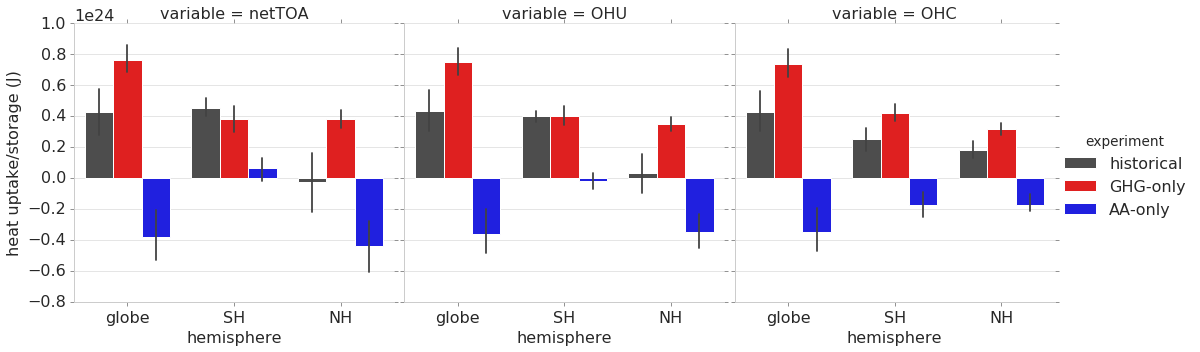

In [9]:
sns.set_style("whitegrid")
sns.catplot(x="hemisphere", y="heat uptake/storage (J)",
            hue="experiment", col="variable",
            data=heat_df, kind="bar",
            palette=['0.3', 'red', 'blue'])
plt.show()
#height=4, aspect=.7)

In [10]:
hemisphere_df = heat_df[heat_df.hemisphere != 'globe']

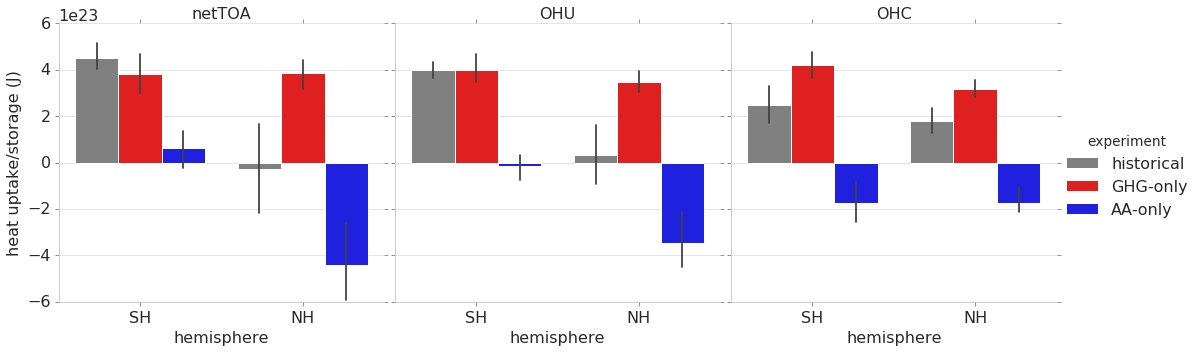

In [12]:
#custom = {'xtick.bottom': False, 'xtick.right': False}
sns.set_style("whitegrid")

g = sns.catplot(x="hemisphere", y="heat uptake/storage (J)",
               hue="experiment", col="variable",
               data=hemisphere_df, kind="bar",
               palette=['0.5', 'red', 'blue'])
g.set_titles("{col_name}")
#plt.show()
plt.savefig('/g/data/r87/dbi599/figures/energy-check-global/ohc-hfds-rndt-nh-sh-sum-boxplot_yr_ensemble_historicalGHGAA_r1i1p1_all.png', dpi=200)

In [15]:
uptake_df = hemisphere_df[hemisphere_df.variable != 'OHC']
uptake_df.rename(columns={'heat uptake/storage (J)': 'heat uptake (J)'}, inplace=True)

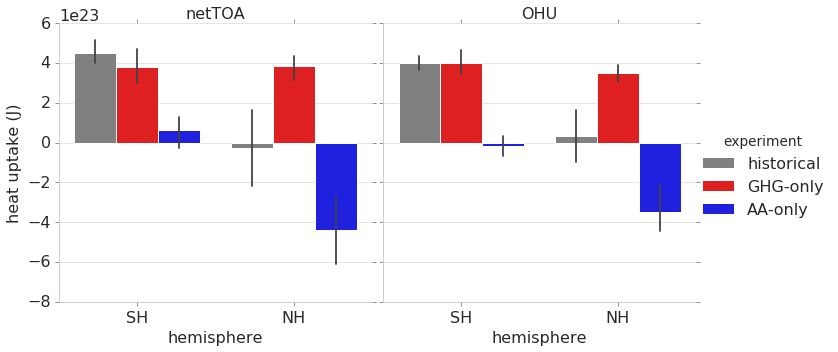

In [16]:
sns.set_style("whitegrid")

g = sns.catplot(x="hemisphere", y="heat uptake (J)",
               hue="experiment", col="variable",
               data=uptake_df, kind="bar",
               palette=['0.5', 'red', 'blue'])
g.set_titles("{col_name}")
#plt.show()
plt.savefig('/g/data/r87/dbi599/figures/energy-check-global/hfds-rndt-nh-sh-sum-boxplot_yr_ensemble_historicalGHGAA_r1i1p1_all.png', dpi=200)

In [17]:
ohc_df = hemisphere_df[hemisphere_df.variable == 'OHC']
ohc_df.rename(columns={'heat uptake/storage (J)': 'change in OHC (J)'}, inplace=True)

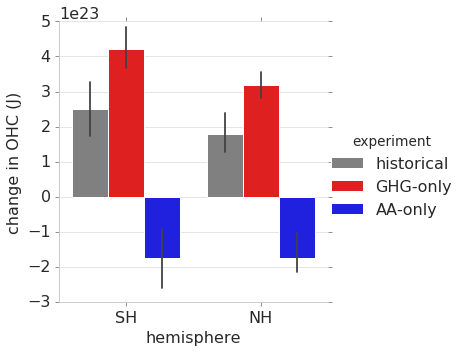

In [18]:
sns.set_style("whitegrid")

g = sns.catplot(x="hemisphere", y="change in OHC (J)",
               hue="experiment",
               data=ohc_df, kind="bar",
               palette=['0.5', 'red', 'blue'])
g.set_titles("{col_name}")
#plt.show()
plt.savefig('/g/data/r87/dbi599/figures/energy-check-global/ohc-nh-sh-sum-boxplot_yr_ensemble_historicalGHGAA_r1i1p1_all.png', dpi=200)

In [36]:
column_list = []
for experiment in ['historical', 'historicalGHG', 'historicalMisc']:
    time_constraint = get_time_constraint(experiment)
    for model in ['CanESM2', 'CCSM4', 'CSIRO-Mk3-6-0', 'GISS-E2-R', 'NorESM1-M']:
        nh_file, sh_file = get_file_pair('thetao', model, experiment)
        values = calc_hemispheric_temperature(nh_file, sh_file, 'thetao', time_constraint)
        column_list = generate_temperature_row_dicts(column_list, values, model, experiment, var)

temperature_df = pandas.DataFrame(column_list)

In [37]:
temperature_df

,change in average temperature (C),experiment,hemisphere,model
0,0.465075,historical,SH,CanESM2
1,0.409071,historical,NH,CanESM2
2,0.094169,historical,SH,CCSM4
3,0.092252,historical,NH,CCSM4
4,0.036806,historical,SH,CSIRO-Mk3-6-0
5,0.042083,historical,NH,CSIRO-Mk3-6-0
6,0.101506,historical,SH,GISS-E2-R
7,0.109014,historical,NH,GISS-E2-R
8,0.059246,historical,SH,NorESM1-M
9,0.037273,historical,NH,NorESM1-M


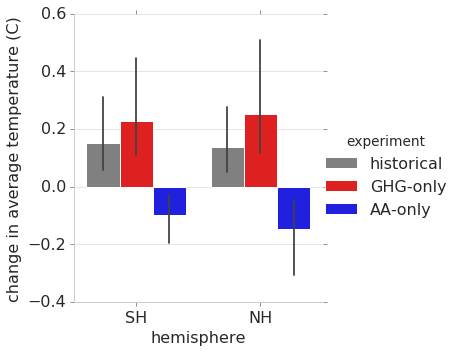

In [38]:
sns.set_style("whitegrid")

sns.catplot(x="hemisphere", y="change in average temperature (C)",
               hue="experiment",
               data=temperature_df, kind="bar",
               palette=['0.5', 'red', 'blue'])
#g.set_titles("{col_name}")

In [57]:
dir(g)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_bottom_axes',
 '_clean_axis',
 '_col_var',
 '_col_wrap',
 '_colors',
 '_dropna',
 '_facet_color',
 '_facet_plot',
 '_finalize_grid',
 '_get_palette',
 '_hue_var',
 '_inner_axes',
 '_left_axes',
 '_legend',
 '_legend_data',
 '_legend_out',
 '_margin_titles',
 '_n_facets',
 '_ncol',
 '_not_bottom_axes',
 '_not_left_axes',
 '_not_na',
 '_nrow',
 '_row_var',
 '_space_needed',
 '_update_legend_data',
 '_x_var',
 '_y_var',
 'add_legend',
 'ax',
 'axes',
 'col_names',
 'data',
 'despine',
 'facet_axis',
 'facet_data',
 'fig',
 'hue_kws',
 'hue_names',
 'map',
 'map_dataframe',
 'row_names',
 'savefig',
 'set',
 'set_axis_label

In [58]:
help(g.set_titles)

Help on method set_titles in module seaborn.axisgrid:

set_titles(template=None, row_template=None, col_template=None, **kwargs) method of seaborn.axisgrid.FacetGrid instance
    Draw titles either above each facet or on the grid margins.
    
    Parameters
    ----------
    template : string
        Template for all titles with the formatting keys {col_var} and
        {col_name} (if using a `col` faceting variable) and/or {row_var}
        and {row_name} (if using a `row` faceting variable).
    row_template:
        Template for the row variable when titles are drawn on the grid
        margins. Must have {row_var} and {row_name} formatting keys.
    col_template:
        Template for the row variable when titles are drawn on the grid
        margins. Must have {col_var} and {col_name} formatting keys.
    
    Returns
    -------
    self: object
        Returns self.



In [76]:
sns.axes_style()

{'axes.axisbelow': True,
 'axes.edgecolor': '.8',
 'axes.facecolor': 'white',
 'axes.grid': True,
 'axes.labelcolor': '.15',
 'figure.facecolor': 'white',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'grid.color': '.8',
 'grid.linestyle': '-',
 'image.cmap': 'rocket',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'text.color': '.15',
 'xtick.color': '.15',
 'xtick.direction': 'out',
 'ytick.color': '.15',
 'ytick.direction': 'out'}